# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
from datetime import date, timedelta
import datetime as dt
from dateutil.relativedelta import relativedelta
import time

# Volatility & Stock Paths

In [2]:
def time_splits(T, n):

    def calculate_expiry(T):
        today = date.today()
        days = T * 365.25  # Approximate days for given T years
        months = int(days // 30.4375)  # Approximate number of months (average month length)
        remaining_days = int(days - months * 30.4375)  # Remaining days after converting to months
        expiry = today + relativedelta(months=+months, days=+remaining_days)
        return expiry

    # Calculate expiry date based on T years
    today = date.today()
    expiry = calculate_expiry(T)

    # Generate n evenly spaced time points in years between today and expiry
    times = [i * T / (n - 1) for i in range(n)]  # Time points in years from 0 to T
    dates = [today + timedelta(days=int(time * 365.25)) for time in times]  # Convert to dates

    return {'times': times, 'dates': dates}

The function below returns the volatility and stock paths.

In [3]:
#Updated Model.  Optimized runtime.

def volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T):
    times = time_splits(T, n)['times']
    dt = np.diff(times)

    V = np.zeros((N, n))
    S = np.zeros((N, n))

    V[:, 0] = v0
    S[:, 0] = S0

    # Generate all random samples at once
    rng = np.random.default_rng()
    mean = [0, 0]
    cov = [[1, corr], [corr, 1]]
    samples = rng.multivariate_normal(mean, cov, size=(N, n))

    for i in range(1, n):
        sqrt_dt = np.sqrt(dt[i - 1])

        V[:, i] = V[:, i - 1] + kappa * (theta - V[:, i - 1]) * dt[i - 1] + eps * sqrt_dt * np.sqrt(V[:, i - 1]) * samples[:, i, 1]
        V[:, i] = np.maximum(V[:, i], 0)

        S[:, i] = S[:, i - 1] * np.exp((r - q - V[:, i - 1] / 2) * dt[i - 1] + np.sqrt(V[:, i - 1] * dt[i - 1]) * samples[:, i, 0])
        S[:, i] = np.maximum(S[:, i], 0)

    return {'volatility paths': V, 'stock paths': S, 'Time (years)': times}

See miscellaneous for previous models (worse runtime using for loops).

# Visualization of Paths

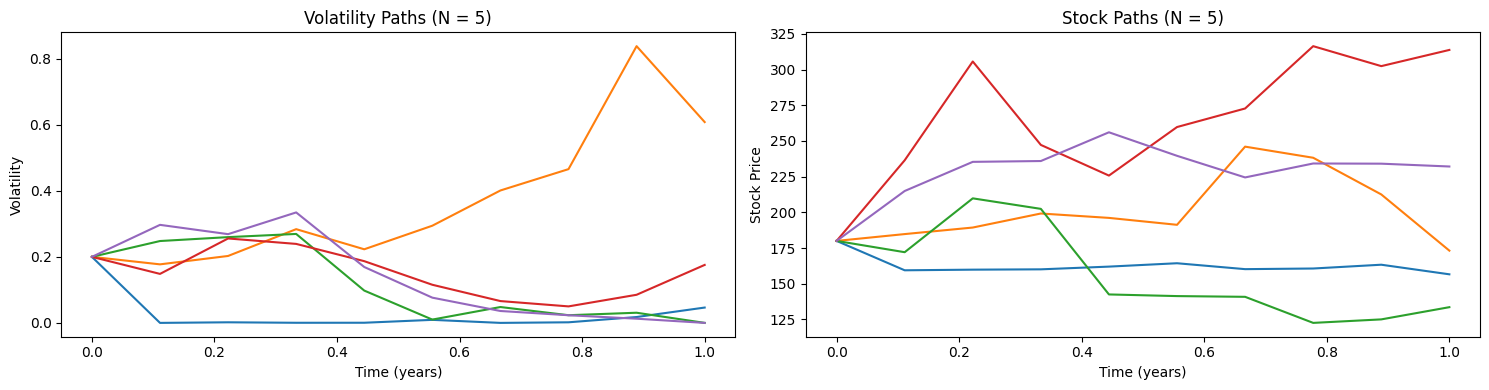

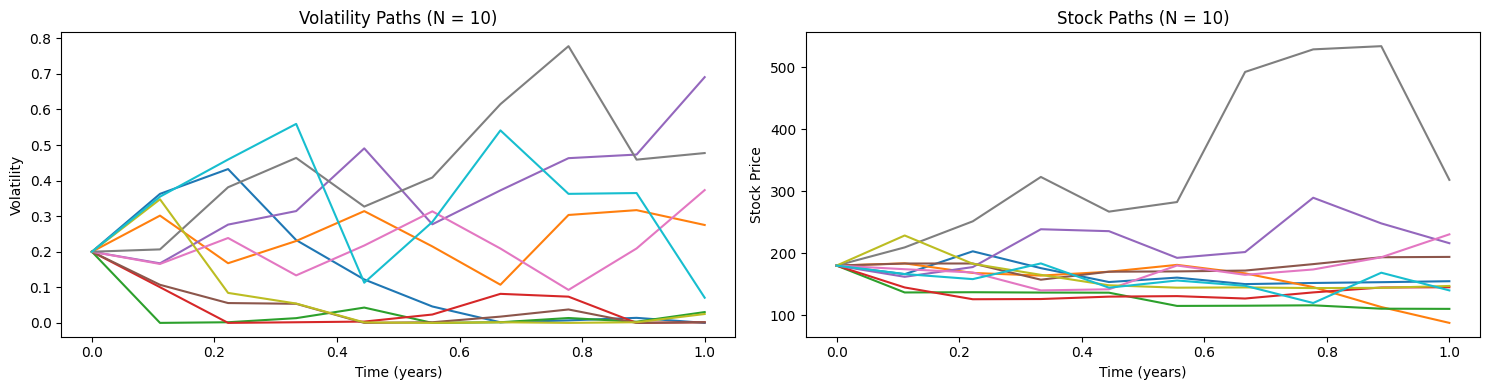

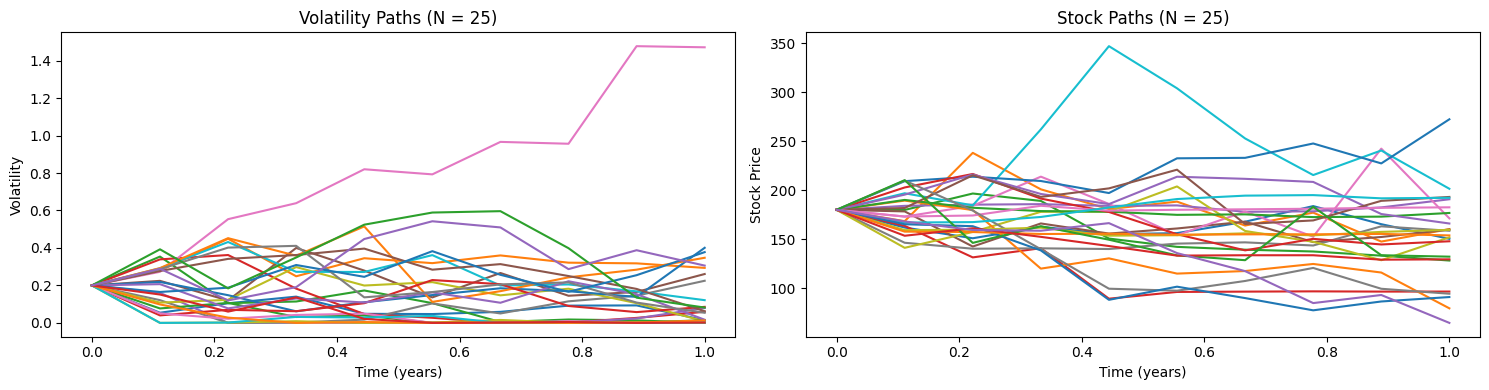

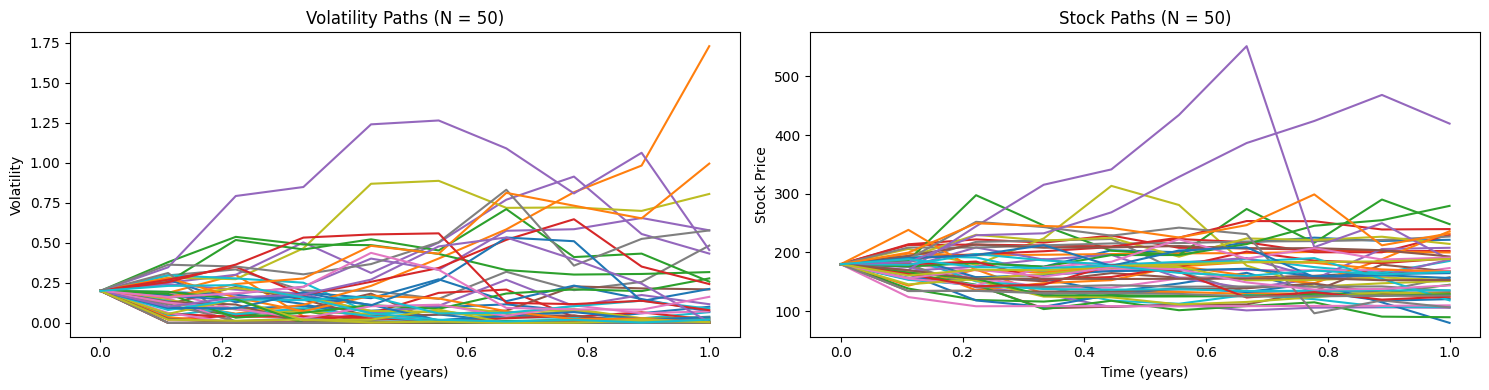

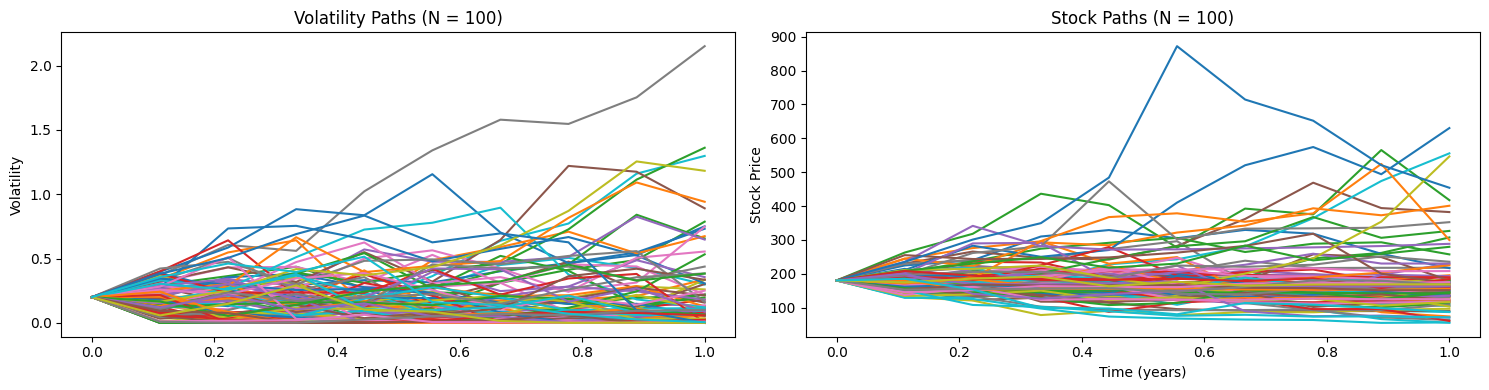

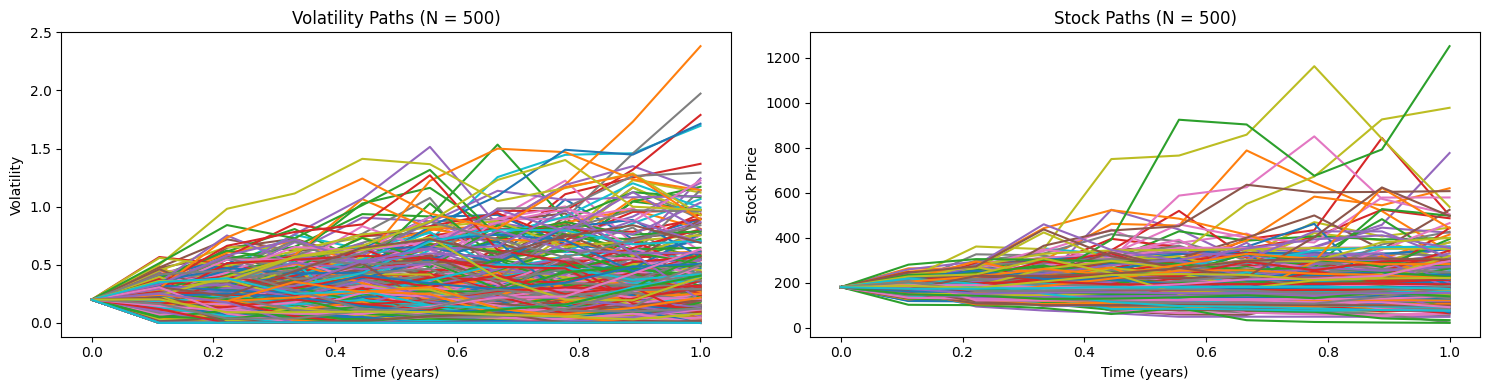

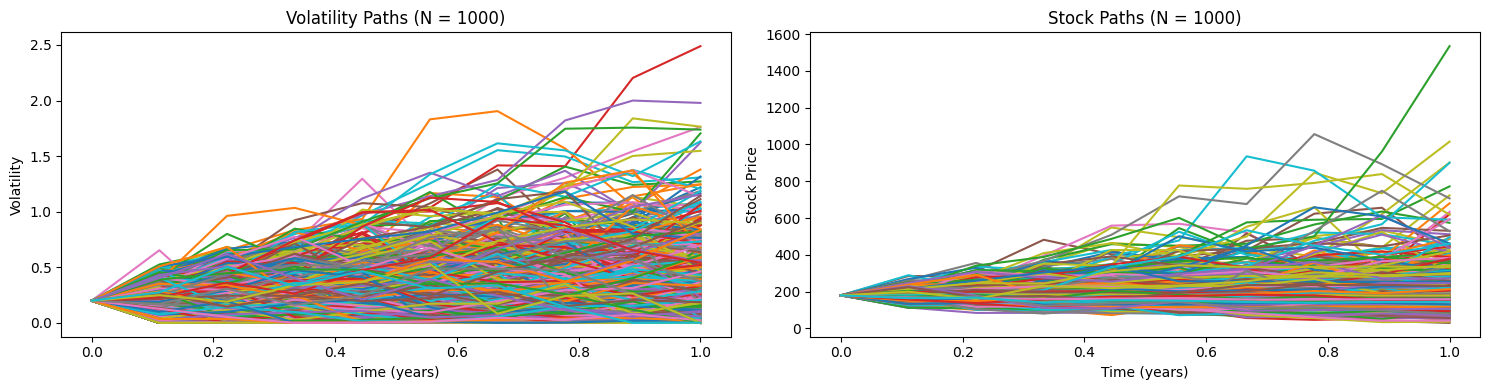

In [4]:
# Parameters
S0 = 180  # Initial stock price
r = 0.04  # Risk-free rate
q = 0.015 # Dividend yield
kappa = 0.08  # Mean reversion speed
theta = 0.20  # Long-term volatility
v0 = 0.20  # Initial volatility
eps = 0.80  # Volatility of volatility
corr = 0.4  # Correlation between stock and volatility
T = 1 #number of years
n = 10  # Number of time steps (within T years)
N_values = [5, 10, 25, 50, 100, 500, 1000] #Number of simulations, will iterate through each.

for N in N_values:

    result = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)

    for path in result['volatility paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Volatility Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Volatility')

    plt.subplot(1, 2, 2)
    for path in result['stock paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Stock Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')

    plt.tight_layout()
    plt.show()


# European Call Option - Heston Model

## Set Parameters

In [5]:
# Heston model parameters
# kappa: mean reversion rate for v(t)
# theta: long-run average of v(t)
# v0: initial squared volatility
# eps: volatility of volatility
# corr: correlation between the standard GM underlying S(t) and v(t)
kappa, theta, v0, eps, corr = 0.8, 0.20, 0.10, 0.80, -0.1

# Monte Carlo parameters
# n: number of time steps
# N: number of simulation paths
n, N = 10, 100000

# European call option parameters
# Strike ranges from 150, 155, ..., 210
S0, T, r, q = 180, 1/12, 0.04, 0.015
strikes = [i for i in range(150, 215, 5)]

## Monte Carlo Derivative Pricing w/ Heston Model

Pricing a European call option using the Heston model.

In [6]:
data = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)

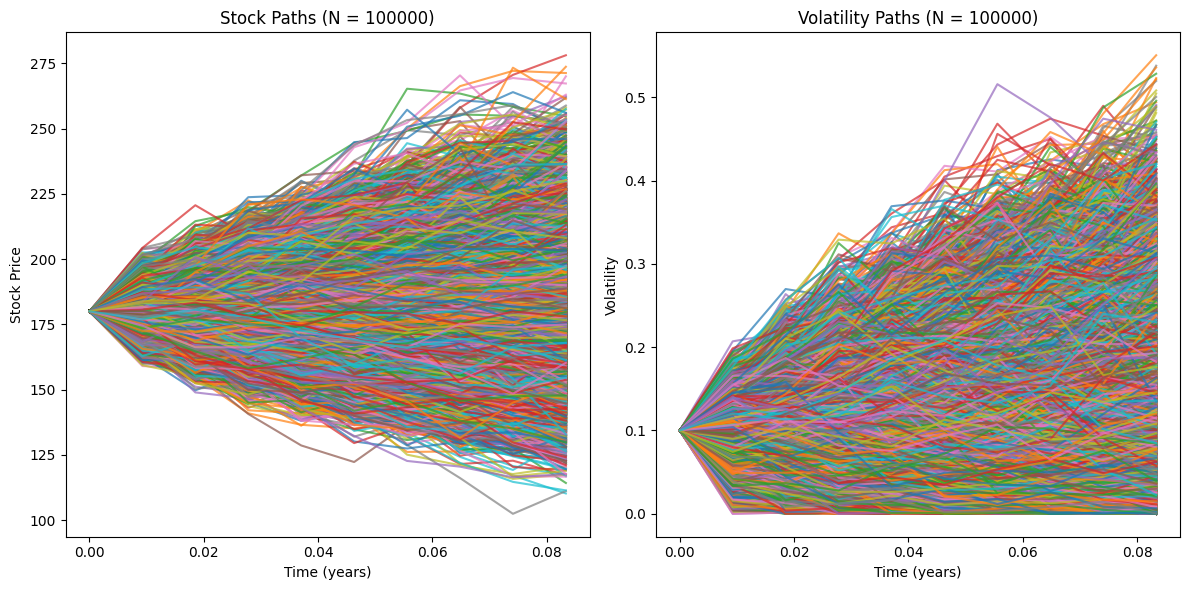

In [7]:
stock_paths = np.array(data['stock paths'])
vol_paths = np.array(data['volatility paths'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(data['Time (years)'], stock_paths.T, alpha=0.7)  # Transpose to plot each path in a single call
axs[1].plot(data['Time (years)'], vol_paths.T, alpha=0.7)  # Same for volatility

axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Stock Price')
axs[0].set_title(f'Stock Paths (N = {N})')

axs[1].set_xlabel('Time (years)')
axs[1].set_ylabel('Volatility')
axs[1].set_title(f'Volatility Paths (N = {N})')

plt.tight_layout()
plt.show()


Now we want to verify the distribution of the stock price at maturity T.  The distribution of the stock price is log normal which appears as normal in this situation due to large mean and low variance.  If we were to adjust the spot closer towards 0 then we would see a more "typical" log normal distribution.

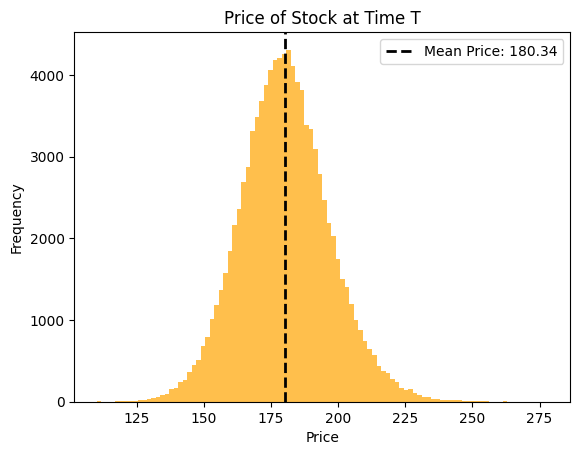

In [8]:
ST = [data['stock paths'][i][-1] for i in range(len(data['stock paths']))]
mean_price = np.mean(ST)
plt.hist(ST, bins=100, color='orange', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price of Stock at Time T')
plt.axvline(x=mean_price, color='black', linestyle='--', linewidth=2, label=f'Mean Price: {mean_price:.2f}')
plt.legend();

Similarly we want to inspect the distribution of the volatility price at maturity T.  There appears to be significant skew which makes sense since the volatility paths are simulated using a standard bivariate normal random variable and they cannot be negative.

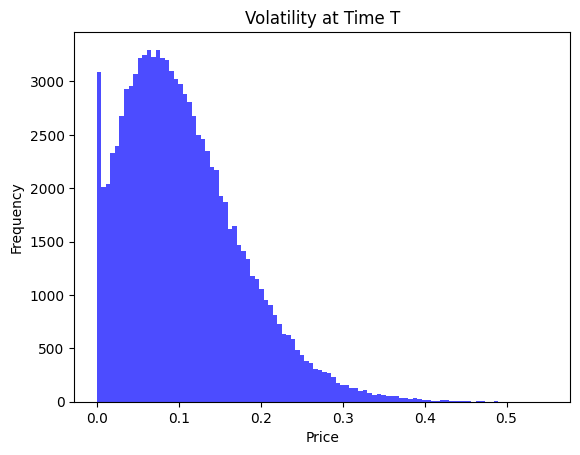

In [9]:
volT = [data['volatility paths'][i][-1] for i in range(len(data['volatility paths']))]
plt.hist(volT, bins=100, color='blue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Volatility at Time T');

Now to calculate the option price by taking the payoff and discounting for each simulation, then taking the mean of all N simulations (to reduce variance).

In [10]:
def call_option_price_heston(S0, T, r, q, K, kappa=None, theta=None, v0=None, eps=None, corr=None, n=None, N=None):

    """Ensure missing parameters have default values"""
    kappa = kappa if kappa is not None else 0.8    # Default kappa
    theta = theta if theta is not None else 0.20   # Default theta
    v0 = v0 if v0 is not None else 0.10            # Default v0
    eps = eps if eps is not None else 0.80         # Default eps
    corr = corr if corr is not None else -0.1      # Default corr
    n = n if n is not None else 10                 # Default n (number of time steps)
    N = N if N is not None else 100000             # Default N (number of simulations)

    data = volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T)
    ST = np.array([data['stock paths'][i][-1] for i in range(len(data['stock paths']))])
    disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
    sim_price = np.mean(disc_payoffs)
    return sim_price


Let us run each option price for each strike M times.  This should be computationally expensive.

In [11]:
M = 20 #number of prices simulated for ladder of strikes

start_time = time.time()

heston_prices_ladder = {k:[] for k in strikes}
for i in range(M):
  for k in strikes:
    heston_prices_ladder[k].append(call_option_price_heston(S0, T, r, q, k))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

df_multiple_sims = pd.DataFrame(heston_prices_ladder).T.reset_index()
df_multiple_sims = df_multiple_sims.rename(columns = {'index':'Strikes'})
for i in range(M):
  df_multiple_sims = df_multiple_sims.rename(columns = {i:f'Price {i}'})

df_multiple_sims['Average Price'] = df_multiple_sims.loc[:,'Price 1':].mean(axis = 1)
df_multiple_sims

Execution time: 55.8665 seconds


,Strikes,Price 0,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7,Price 8,...,Price 11,Price 12,Price 13,Price 14,Price 15,Price 16,Price 17,Price 18,Price 19,Average Price
0,150,30.479144,30.474112,30.410270,30.369908,30.470745,30.481556,30.501346,30.529999,30.428833,...,30.439421,30.554630,30.452105,30.539914,30.535077,30.404787,30.438574,30.537835,30.390174,30.471488
1,155,25.762033,25.678808,25.749370,25.646719,25.764862,25.714908,25.749951,25.718560,25.676160,...,25.742442,25.685992,25.769666,25.685981,25.715994,25.663322,25.680650,25.647530,25.666651,25.699496
2,160,21.095348,21.083880,21.126763,21.024880,21.130819,21.100633,21.080325,21.094419,21.209349,...,21.094588,21.095585,21.092559,21.139845,20.977016,21.111551,21.116624,21.148437,21.082296,21.097928
3,165,16.752367,16.810187,16.855829,16.887872,16.826358,16.763158,16.856741,16.804830,16.736813,...,16.805464,16.851265,16.827526,16.815294,16.801292,16.792167,16.808032,16.835198,16.842831,16.816528
4,170,12.933103,12.983671,12.928219,12.912688,12.895234,12.930809,12.980869,12.902879,12.939328,...,12.874276,12.909843,12.849804,12.913794,12.829462,12.876171,12.928642,12.908893,12.958621,12.912354
5,175,9.424647,9.442384,9.456034,9.413622,9.518091,9.537277,9.517520,9.475406,9.504441,...,9.468465,9.447523,9.503726,9.526586,9.560180,9.511225,9.479147,9.510642,9.469894,9.493176
6,180,6.696030,6.736684,6.721880,6.700394,6.736013,6.685141,6.684541,6.662425,6.668909,...,6.690377,6.683471,6.706305,6.728041,6.731279,6.662260,6.714718,6.690295,6.724017,6.700065
7,185,4.551559,4.511644,4.536594,4.515373,4.524005,4.544762,4.593155,4.503303,4.534699,...,4.496603,4.536464,4.483465,4.547473,4.499243,4.567584,4.489184,4.506701,4.537929,4.530962
8,190,2.946366,2.954856,2.981465,2.936677,2.961206,2.938254,2.938839,2.960755,2.949838,...,2.953393,2.942101,2.945185,2.939654,2.950798,2.979055,2.924303,2.970975,2.962960,2.950974
9,195,1.829009,1.848930,1.835069,1.818785,1.884434,1.809246,1.844891,1.851173,1.851362,...,1.847439,1.859192,1.846524,1.853329,1.835139,1.848711,1.838862,1.840990,1.857440,1.846115


# Implied Volatility & Volatility Smile

Now, clearly the computational costs pose an issue.  Therefore, assume that 1 simulation is enough, and assume our Heston model estimate is the marekt price for the European call option.  Let us calculate the implied volatility assuming this price is the BSM price on the market.

In [13]:
def implied_volatility(S0, T, r, q, K, market_price):

    def BSM_call_price(S0, T, r, q, K, v):
      d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
      d2 = d1 - v*np.sqrt(T)
      price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
      return price

    def objective(v):
        bsm_price = BSM_call_price(S0, T, r, q, K, v)
        return bsm_price - market_price

    return optimize.newton(objective, x0=0.3)

In [14]:
def BSM_call_price(S0, T, r, q, K, v):
  d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
  d2 = d1 - v*np.sqrt(T)
  price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
  return price

S0, T, r, q = 180, 1/12, 0.04, 0.015

df_vol_cal = df_multiple_sims.drop(columns = 'Average Price')
strikes = list(df_vol_cal['Strikes'].values)
prices = list(df_vol_cal.columns)[1:]  # Column names excluding 'Strikes'
vol_smile = [f'vol smile {i}' for i in range(df_vol_cal.shape[1] - 1)]

implied_vol_dict = {v: [] for v in vol_smile}

df_vol_cal['Lower Bound'] = [BSM_call_price(S0, T, r, q, k, 10**-5) for k in strikes]
for i, price_col in enumerate(list(df_vol_cal.columns)[1:-1]):  # Exclude 'Strikes' & 'Lower Bound'
    df_vol_cal[f'Convergence {i+1}'] = (df_vol_cal[price_col] - df_vol_cal['Lower Bound']) >= 0
convergence_cols = [col for col in df_vol_cal.columns if 'Convergence' in col]
df_vol_cal['Convergence'] = df_vol_cal[convergence_cols].all(axis=1)
df_vol_cal.drop(columns=convergence_cols, inplace=True)
df_vol_cal

,Strikes,Price 0,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7,Price 8,...,Price 12,Price 13,Price 14,Price 15,Price 16,Price 17,Price 18,Price 19,Lower Bound,Convergence
0,150,30.479144,30.474112,30.410270,30.369908,30.470745,30.481556,30.501346,30.529999,30.428833,...,30.554630,30.452105,30.539914,30.535077,30.404787,30.438574,30.537835,30.390174,30.274308,True
1,155,25.762033,25.678808,25.749370,25.646719,25.764862,25.714908,25.749951,25.718560,25.676160,...,25.685992,25.769666,25.685981,25.715994,25.663322,25.680650,25.647530,25.666651,25.290947,True
2,160,21.095348,21.083880,21.126763,21.024880,21.130819,21.100633,21.080325,21.094419,21.209349,...,21.095585,21.092559,21.139845,20.977016,21.111551,21.116624,21.148437,21.082296,20.307586,True
3,165,16.752367,16.810187,16.855829,16.887872,16.826358,16.763158,16.856741,16.804830,16.736813,...,16.851265,16.827526,16.815294,16.801292,16.792167,16.808032,16.835198,16.842831,15.324225,True
4,170,12.933103,12.983671,12.928219,12.912688,12.895234,12.930809,12.980869,12.902879,12.939328,...,12.909843,12.849804,12.913794,12.829462,12.876171,12.928642,12.908893,12.958621,10.340864,True
5,175,9.424647,9.442384,9.456034,9.413622,9.518091,9.537277,9.517520,9.475406,9.504441,...,9.447523,9.503726,9.526586,9.560180,9.511225,9.479147,9.510642,9.469894,5.357503,True
6,180,6.696030,6.736684,6.721880,6.700394,6.736013,6.685141,6.684541,6.662425,6.668909,...,6.683471,6.706305,6.728041,6.731279,6.662260,6.714718,6.690295,6.724017,0.374142,True
7,185,4.551559,4.511644,4.536594,4.515373,4.524005,4.544762,4.593155,4.503303,4.534699,...,4.536464,4.483465,4.547473,4.499243,4.567584,4.489184,4.506701,4.537929,0.000000,True
8,190,2.946366,2.954856,2.981465,2.936677,2.961206,2.938254,2.938839,2.960755,2.949838,...,2.942101,2.945185,2.939654,2.950798,2.979055,2.924303,2.970975,2.962960,0.000000,True
9,195,1.829009,1.848930,1.835069,1.818785,1.884434,1.809246,1.844891,1.851173,1.851362,...,1.859192,1.846524,1.853329,1.835139,1.848711,1.838862,1.840990,1.857440,0.000000,True


All optimization will indeed converge.  Therefore all volatility smiles exist.  Calculating and plotting the volatility smiles below as follows:

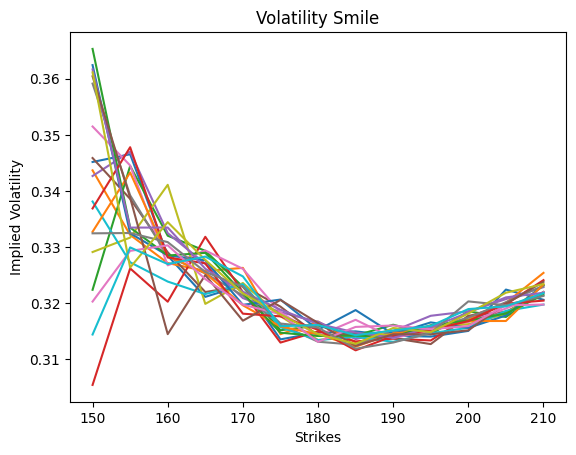

In [15]:
for vol_sm_i, pr_col in zip(vol_smile, prices):
    for k in strikes:
        K = k
        market_price = df_vol_cal.loc[df_vol_cal['Strikes'] == K, pr_col].values[0]  # Extract correct price
        implied_vol_dict[vol_sm_i].append(implied_volatility(S0, T, r, q, K, market_price))

keys = list(implied_vol_dict.keys())
for i in range(len(keys)):
  plt.plot(strikes, implied_vol_dict[keys[i]])

plt.title('Volatility Smile')
plt.xlabel('Strikes');
plt.ylabel('Implied Volatility');

Using Monte Carlo simulation for the Heston model rather than the semi-analytical solution leads to unusual behavior in your volatility smiles.

Monte Carlo Simulation Accuracy at the Wings:

*   Deep out-of-the-money (OTM) options at extreme strikes have very few paths that end up in-the-money
*   This means your payoff estimation becomes less reliable at the wings
*   The problem is especially acute for low strikes where you need many paths to capture rare large downward moves

Sample Size Limitations:



*   While 100,000 paths might seem large, for extreme strikes you might need many more paths
*   The variance of your estimator increases significantly at the wings
*   This explains why your smiles look unstable at the edges (particularly around strike 150)


To improve the results, I could:


*   Increase the number of paths (try 1,000,000 or more)
*   Use variance reduction techniques such as Antithetic sampling

We can easily address the issue of the tails by taking the median value of each implied volatility at each strike in order fix the tail issues at the end.

In [16]:
vol_smile_df = pd.DataFrame(implied_vol_dict)
vol_smile_df['Median Implied Volatility'] = vol_smile_df.median(axis = 1)
vol_smile_df['Mean Implied Volatility'] = vol_smile_df.mean(axis = 1)
vol_smile_df.insert(0, 'Strikes', strikes)
vol_smile_df


,Strikes,vol smile 0,vol smile 1,vol smile 2,vol smile 3,vol smile 4,vol smile 5,vol smile 6,vol smile 7,vol smile 8,...,vol smile 12,vol smile 13,vol smile 14,vol smile 15,vol smile 16,vol smile 17,vol smile 18,vol smile 19,Median Implied Volatility,Mean Implied Volatility
0,150,0.345162,0.343671,0.322370,0.305407,0.342661,0.345868,0.351489,0.359138,0.329103,...,0.365324,0.336874,0.361668,0.360441,0.320272,0.332437,0.361142,0.314396,0.343166,0.341612
1,155,0.346544,0.332162,0.344447,0.326184,0.347009,0.338581,0.344543,0.339214,0.331679,...,0.333464,0.347795,0.333462,0.338769,0.329312,0.332497,0.326339,0.329930,0.333463,0.336115
2,160,0.328457,0.327143,0.332012,0.320247,0.332467,0.329059,0.326735,0.328351,0.341090,...,0.328484,0.328138,0.333476,0.314463,0.330298,0.330871,0.334431,0.326961,0.328470,0.328660
3,165,0.321108,0.325717,0.329315,0.331820,0.326996,0.321973,0.329386,0.325293,0.319858,...,0.328957,0.327088,0.326122,0.325012,0.324287,0.325547,0.327693,0.328294,0.325920,0.325951
4,170,0.323203,0.326278,0.322905,0.321958,0.320892,0.323063,0.326108,0.321359,0.323582,...,0.321784,0.318111,0.322026,0.316863,0.319727,0.322931,0.321726,0.324756,0.321992,0.321997
5,175,0.313529,0.314450,0.315158,0.312957,0.318376,0.319370,0.318346,0.316163,0.317668,...,0.314717,0.317631,0.318816,0.320556,0.318020,0.316357,0.317990,0.315877,0.316994,0.316910
6,180,0.314739,0.316707,0.315990,0.314950,0.316674,0.314211,0.314182,0.313112,0.313426,...,0.314130,0.315236,0.316288,0.316445,0.313104,0.315643,0.314461,0.316093,0.314844,0.314920
7,185,0.314955,0.312974,0.314213,0.313159,0.313588,0.314618,0.317019,0.312560,0.314119,...,0.314206,0.311575,0.314753,0.312358,0.315751,0.311859,0.312729,0.314279,0.314051,0.313987
8,190,0.314191,0.314662,0.316138,0.313653,0.315015,0.313741,0.313773,0.314990,0.314384,...,0.313954,0.314125,0.313818,0.314437,0.316004,0.312965,0.315556,0.315112,0.314410,0.314433
9,195,0.314022,0.315360,0.314429,0.313333,0.317736,0.312689,0.315089,0.315511,0.315523,...,0.316048,0.315199,0.315655,0.314434,0.315346,0.314684,0.314827,0.315931,0.315230,0.315118


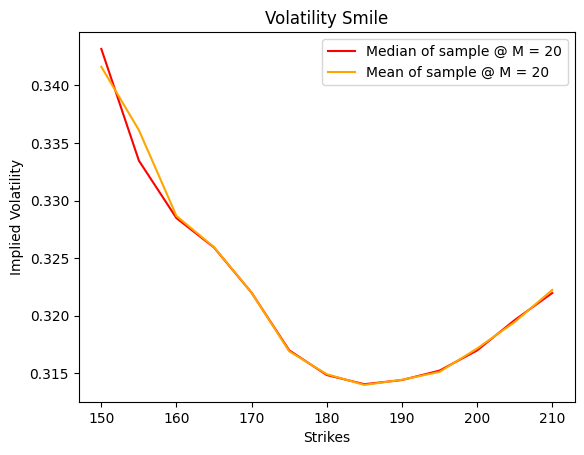

In [17]:
plt.plot(vol_smile_df['Strikes'], vol_smile_df['Median Implied Volatility'], color='red',
         label=f'Median of sample @ M = {M}')
plt.plot(vol_smile_df['Strikes'], vol_smile_df['Mean Implied Volatility'], color='orange',
         label=f'Mean of sample @ M = {M}')

plt.title('Volatility Smile')
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')

plt.legend()

plt.show()


This volatility smile looks a lot better.

# Misc.

In [18]:
##Model 1 - Very time inefficient

# def volatility_and_stock_paths(S0, r, q, kappa, theta, v0, eps, corr, n, N, T):

#   times = time_splits(T,n)['times']

#   V = []
#   S = []

#   for j in range(N):
#       rng = np.random.default_rng()
#       mean = [0, 0]
#       cov = [[1, corr], [corr, 1]]
#       samples = rng.multivariate_normal(mean, cov, size=n, method='cholesky')

#       v = [v0]  # list to store volatility values
#       s = [S0]
#       for i in range(1, n):
#           delta_t = times[i] - times[i - 1]
#           assert delta_t >= 0.00001, print(f'{delta_t} is negative')

#           #n components of volatility path for 1 simulation
#           vi = v[i - 1] + kappa * (theta - v[i - 1]) * delta_t + eps * np.sqrt(v[i - 1] * delta_t) * samples[i, 1]
#           assert v[i - 1] * delta_t >= 0, print(v[i - 1] * delta_t)
#           vi_max = max(vi, 0)
#           v.append(vi_max)

#           #n components of stock path for 1 simulation
#           Si = s[i - 1]*np.exp((r - q - v[i - 1]/2)*delta_t + np.sqrt(v[i - 1]*delta_t)*samples[i, 0]) #make sure to add dividend yield here
#           Si_max = max(Si,0)
#           s.append(Si_max)
#       V.append(v)
#       S.append(s)

#   return {'volatility paths': V, 'stock paths': S, 'Time (years)': times}